In [ ]:
%pip install tensorflow keras nltk scikit-learn transformers


In [ ]:
pip install --upgrade tensorflow

In [ ]:
pip uninstall transformers -y


In [ ]:
pip install google-generativeai

In [ ]:
pip install nltk

In [ ]:
pip install transformers tensorflow torch scikit-learn matplotlib

In [ ]:
pip cache purge

In [ ]:

pip install keras==2.13.1  transformers==4.33.0

In [ ]:
pip show tensorflow keras transformers

In [ ]:
pip install keras==3.0.5 transformers==4.38.1

In [ ]:
# Updated complete code with enhancements, preserving old functions
import os
import json
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import Counter
from sentence_transformers import SentenceTransformer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Dense, Dropout, BatchNormalization,
    Input, Attention, LayerNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# ---- Load Dataset ----
with open("combined_dataset.json", "r") as f:
    parsed_data = [json.loads(line) for line in f if line.strip()]

X_texts = [sample["Context"] for sample in parsed_data]
Y_labels = [sample["Response"] for sample in parsed_data]

bert_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)
try:
    X_emb = np.load("x_embeddings_sbert.npy")
    Y_encoded = np.load("y_encoded.npy")
    with open("response_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)
    print("✅ Loaded saved embeddings and encoder.")
except FileNotFoundError:
    X_emb = sbert_model.encode(X_texts)
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y_labels)
    np.save("x_embeddings_sbert.npy", X_emb)
    np.save("y_encoded.npy", Y_encoded)
    with open("response_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)
    print("✅ Computed and saved embeddings and encoder.")

num_classes = len(label_encoder.classes_)
Y_encoded = to_categorical(Y_encoded, num_classes=num_classes)

# ---- Filter Rare Classes ----
class_counts = Counter(np.argmax(Y_encoded, axis=1))
valid_classes = {cls for cls, count in class_counts.items() if count > 1}
valid_indices = [i for i, label in enumerate(np.argmax(Y_encoded, axis=1)) if label in valid_classes]
X_filtered = X_emb[valid_indices]
Y_filtered = Y_encoded[valid_indices]
filtered_class_counts = Counter(np.argmax(Y_filtered, axis=1))
min_samples_per_class = min(filtered_class_counts.values())

if min_samples_per_class < 2:
    print("⚠️ Skipping SMOTETomek due to class imbalance.")
    X_resampled, Y_resampled = X_filtered, Y_filtered
else:
    smote_k = max(min(5, min_samples_per_class - 1), 1)
    smote = SMOTE(k_neighbors=smote_k, random_state=42)
    X_smote, Y_smote = smote.fit_resample(X_filtered, np.argmax(Y_filtered, axis=1))
    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, Y_resampled = smote_tomek.fit_resample(X_smote, Y_smote)
    Y_resampled = to_categorical(Y_resampled, num_classes=num_classes)

# ---- Train-Test Split ----
num_samples = len(X_resampled)
test_size = min(int(0.2 * num_samples), num_samples - num_classes)
test_size = max(test_size, num_classes)

if len(Y_resampled.shape) > 1:  # If Y_resampled is one-hot encoded
    Y_labels_resampled = np.argmax(Y_resampled, axis=1)  # Convert to integer labels
else:
    Y_labels_resampled = Y_resampled  # Already integer labels

X_train, X_test, Y_train, Y_test = train_test_split(
    X_resampled, Y_labels_resampled, test_size=test_size, random_state=42, stratify=Y_labels_resampled
)

X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# ---- Ensure Y_train and Y_test are always integers ----
if len(Y_train.shape) > 1:  # Only apply np.argmax() if needed
    Y_train = np.argmax(Y_train, axis=1)
    Y_test = np.argmax(Y_test, axis=1)

print(f"✅ X_train shape: {X_train.shape}")  
print(f"✅ Y_train shape: {Y_train.shape}")  
print(f"✅ Y_test shape: {Y_test.shape}") 

y_train_labels = Y_train if Y_train.ndim == 1 else np.argmax(Y_train, axis=1)  # Ensure class weights use integer labels
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = {i: max(w, 0.5) for i, w in enumerate(class_weights)}  # Set min weight of 0.5 to avoid extreme imbalance

# ---- Define or Load Model ----
model_path = "optimized_lstm_model.h5"
prev_model_path = "previous_lstm_model.h5"

# ---- Define or Load Model ----
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

if os.path.exists(model_path):
    print("✅ Loading existing model...")
    model = load_model(model_path)
    optimizer = RMSprop(learning_rate=1e-3)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
else:
    print("🚀 Building new model with attention...")
    input_layer = Input(shape=(1, X_train.shape[-1]))
    x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(input_layer)# Add recurrent dropout
    x = BatchNormalization()(x)

    x    = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    x = BatchNormalization()(x)
    x = LayerNormalization()(x)  # Normalize before attention
    attention = Attention()([x, x])
    x = GlobalAveragePooling1D()(attention)

    x = Dense(256, activation="relu", kernel_initializer=GlorotUniform())(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation="relu", kernel_initializer=GlorotUniform())(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation="softmax")(x)    

    model = Model(inputs=input_layer, outputs=output)

loss_function = "sparse_categorical_crossentropy"
optimizer = Adam(learning_rate=5e-5)  # Lower initial learning rate

model.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

# ---- Train ----
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max")
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=80,  # Increase epochs for better convergence
    batch_size=64,  # Reduce batch size to 32
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)


# ---- Evaluate ----
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"✅ Model Test Accuracy: {test_acc * 100:.2f}%")

# Ensure Y_test is one-hot encoded before evaluating the model
if Y_test.ndim == 1:  # Convert only if it's 1D (integer labels)
    Y_test = to_categorical(Y_test, num_classes=num_classes)

# ---- Save if better ----
prev_model_acc = 0
if os.path.exists("optimized_lstm_model.h5"):
    print("✅ Loading existing model...")
    prev_model = load_model("optimized_lstm_model.h5")
    
    # Explicitly compile the model to avoid warning
    prev_model.compile(
        optimizer = Adam(learning_rate=5e-5),
        loss="categorical_crossentropy",  # Use categorical loss if Y_test is one-hot encoded
        metrics=["accuracy"]
    )

    _, prev_model_acc = prev_model.evaluate(X_test, Y_test, verbose=0)

if test_acc > prev_model_acc+0.005:
    if os.path.exists(model_path):
        os.rename(model_path, prev_model_path)  # Keep previous model
    model.save(model_path)
    print(f"✅ Improved model saved as `{model_path}`.")
    print(f"📂 Previous model saved as `{prev_model_path}`.")
else:
    print(f"⚠️ No improvement. Previous accuracy: {prev_model_acc * 100:.2f}%")

# ---- Plot Accuracy ----
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()


In [ ]:
#Another Version

In [ ]:
pip install sentence-transformers

In [ ]:
import os
import json
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import Counter
from sentence_transformers import SentenceTransformer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Input, LayerNormalization ,Attention, Layer
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import ExponentialDecay

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(1,),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# ---- Step 1: Load Dataset ----
with open("combined_dataset.json", "r") as f:
    lines = f.readlines()
parsed_data = [json.loads(line) for line in lines if line.strip()]

X_texts = [sample["Context"] for sample in parsed_data]
Y_labels = [sample["Response"] for sample in parsed_data]

# ---- Step 2: Load Sentence-BERT Model ----
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

try:
    X_emb = np.load("x_embeddings_sbert.npy")
    Y_int = np.load("y_encoded.npy")
    with open("response_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)
    print("✅ Loaded saved embeddings and encoder.")
except FileNotFoundError:
    X_emb = sbert_model.encode(X_texts)
    label_encoder = LabelEncoder()
    Y_int = label_encoder.fit_transform(Y_labels)
    np.save("x_embeddings_sbert.npy", X_emb)
    np.save("y_encoded.npy", Y_int)
    with open("response_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)
    print("✅ Computed and saved embeddings and encoder.")

num_classes = len(label_encoder.classes_)
Y_encoded = to_categorical(Y_int, num_classes=num_classes)

# ---- Filter classes with more than 1 sample ----
class_counts = Counter(Y_int)
valid_classes = {cls for cls, count in class_counts.items() if count > 1}
valid_indices = [i for i, y in enumerate(Y_int) if y in valid_classes]

X_filtered = X_emb[valid_indices]
Y_filtered_int = np.array(Y_int)[valid_indices]

filtered_class_counts = Counter(Y_filtered_int)
print(f"📊 Filtered Class Distribution: {filtered_class_counts}")

# ---- SMOTE + TomekLinks ----
min_samples_per_class = min(filtered_class_counts.values())
if min_samples_per_class < 2:
    print("⚠️ Not enough samples for SMOTE.")
    X_resampled, Y_resampled_int = X_filtered, Y_filtered_int
else:
    smote_k = max(min(5, min_samples_per_class - 1), 1)
    smote = SMOTE(k_neighbors=smote_k, random_state=42)
    X_smote, Y_smote_int = smote.fit_resample(X_filtered, Y_filtered_int)

    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, Y_resampled_int = smote_tomek.fit_resample(X_smote, Y_smote_int)
    print(f"📊 After SMOTETomek: {Counter(Y_resampled_int)}")

Y_resampled = to_categorical(Y_resampled_int, num_classes=num_classes)

# ---- Train-Test Split ----
test_size = max(min(int(0.2 * len(X_resampled)), len(X_resampled) - num_classes), num_classes)
X_train, X_test, Y_train, Y_test, Y_train_int, Y_test_int = train_test_split(
    X_resampled, Y_resampled, Y_resampled_int, test_size=test_size, stratify=Y_resampled_int, random_state=42
)

print(f"✅ Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# ---- Reshape Input for LSTM ----
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# ---- Compute Class Weights ----
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_int), y=Y_train_int)
class_weight_dict = dict(enumerate(class_weights))

# ---- Define Learning Rate Schedule ----
lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1500, decay_rate=0.9)

# ---- Load or Define Model ----
model_path = "optimized_lstm_model.h5"

# ---- Define Model with Attention ----
if os.path.exists(model_path):
    print("✅ Loading existing model...")
    model = load_model(model_path, custom_objects={"Attention": Attention})
    optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
    model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1), optimizer=optimizer, metrics=["accuracy"])
else:
    print("🚀 No model found. Training from scratch...")
    model = Sequential([
        Input(shape=(1, X_train.shape[-1])),
        Bidirectional(LSTM(256, return_sequences=True)),
        LayerNormalization(),
        Dropout(0.3),

        Bidirectional(LSTM(256, return_sequences=True)),
        LayerNormalization(),
        Dropout(0.3),

        AttentionLayer(),
        Dropout(0.3),

        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(num_classes, activation="softmax")
    ])
    optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
    model.compile(optimizer=optimizer,
                  loss=CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=["accuracy"])

# ---- Callbacks ----
early_stopping = EarlyStopping(monitor="val_loss", patience=9, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1)

# ---- Train ----
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

# ---- Save ----
model.save(model_path)

# ---- Evaluate ----
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"✅ Final Test Accuracy: {test_acc * 100:.2f}%")

# ---- Step 9: Save the Best Model ----
prev_model_acc = 0
if os.path.exists("optimized_lstm_model.h5"):
    prev_model = load_model("optimized_lstm_model.h5")
    _, prev_model_acc = prev_model.evaluate(X_test, Y_test, verbose=0)

_, new_model_acc = model.evaluate(X_test, Y_test, verbose=0)

if new_model_acc > prev_model_acc:
    model.save("optimized_lstm_model.h5")
    print(f"✅ New model saved with improved accuracy: {new_model_acc * 100:.2f}%")
else:
    print(f"⚠️ New model did NOT improve accuracy. Keeping previous model: {prev_model_acc * 100:.2f}%")


# Predict
Y_pred_probs = model.predict(X_test)
Y_pred_int = np.argmax(Y_pred_probs, axis=1)


# ---- Step 10: Plot Training vs Validation Accuracy ----
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Best Model
import os
import json
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gc
import tensorflow as tf
from tensorflow.keras import backend as K  # To clear memory
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Input, Dense, Dropout, LSTM, BatchNormalization, Bidirectional, Layer,
                                     MultiHeadAttention, LayerNormalization, Add)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

# ---- Step 2: Define Attention Layer ----
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                   initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(1,),
                                   initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1]) # Output shape is (batch_size, embedding_dim)

# ---- Step 3: Load and Prepare Dataset ----
with open("combined_dataset.json", "r") as f:
    parsed_data = [json.loads(line) for line in f if line.strip()]

X_texts = [sample["Context"] for sample in parsed_data]
Y_labels = [sample["Response"] for sample in parsed_data]

# ---- Step 4: Define SBERT Variants to Test ----
sbert_variants = [
    'paraphrase-MiniLM-L12-v2'
]
#',
#,     'all-MiniLM-L6-v2',
# ---- Step 5: Encode Labels ----
label_encoder = LabelEncoder()
Y_encoded_labels = label_encoder.fit_transform(Y_labels)
num_classes_original = len(label_encoder.classes_)
Y_encoded = to_categorical(Y_encoded_labels, num_classes=num_classes_original)

# ---- Step 6: Save Label Encoder ----
with open("response_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# ---- Step 7: Remove Rare Classes (only 1 sample) ----
class_counts = Counter(np.argmax(Y_encoded, axis=1))
valid_classes = {cls for cls, count in class_counts.items() if count > 1}
valid_indices = [i for i, label in enumerate(np.argmax(Y_encoded, axis=1)) if label in valid_classes]

X_texts_filtered = [X_texts[i] for i in valid_indices]
Y_filtered = Y_encoded[valid_indices]
Y_filtered_encoded_labels = np.argmax(Y_filtered, axis=1) # Get integer labels after filtering

filtered_class_counts = Counter(Y_filtered_encoded_labels)
min_samples_per_class = min(filtered_class_counts.values())
print(f"📊 Filtered Class Distribution: {filtered_class_counts}")

# ---- Step 8: Prepare Embeddings and Split Data ----
sbert_model_name = sbert_variants[0] # Using the first variant for this non-function block
print(f"\n🔄 Preparing embeddings with SBERT model: {sbert_model_name}")
sbert = SentenceTransformer(sbert_model_name)
X_emb = sbert.encode(X_texts_filtered)
Y_filtered_encoded_labels_step8 = np.argmax(Y_filtered, axis=1) # Get integer labels after filtering

# Resample using SMOTE + TomekLinks if safe
if min_samples_per_class < 2:
    print("⚠️ SMOTE skipped due to classes with <2 samples.")
    X_resampled, Y_resampled_encoded = X_emb, Y_filtered_encoded_labels_step8
else:
    smote_k = min(5, min_samples_per_class - 1)
    smote_k = max(smote_k, 1)
    print(f"✅ Applying SMOTE with k={smote_k} and TomekLinks...")
    smote = SMOTE(k_neighbors=smote_k, random_state=42)
    X_smote, Y_smote_encoded = smote.fit_resample(X_emb, Y_filtered_encoded_labels_step8)
    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, Y_resampled_encoded = smote_tomek.fit_resample(X_smote, Y_smote_encoded)

unique_resampled_labels = np.unique(Y_resampled_encoded)
current_num_classes = len(unique_resampled_labels)

# --- FIX: Ensure Y_resampled_encoded values are within the valid range ---
Y_resampled_encoded = np.clip(Y_resampled_encoded, 0, current_num_classes - 1)

Y_resampled = to_categorical(Y_resampled_encoded, num_classes=current_num_classes)
print(f"📊 Resampled Class Distribution: {Counter(np.argmax(Y_resampled, axis=1))}")
print(f"🔢 Number of classes after resampling: {current_num_classes}")

# Train-Test Split (75% train, 25% test)
print(f"➡️ Before train_test_split: test_size = 0.25")
X_train, X_test, Y_train, Y_test = train_test_split(
    X_resampled, Y_resampled,
    test_size=0.25,  # 25% for the test set
    random_state=42,
    stratify=np.argmax(Y_resampled, axis=1)
)
print(f"✅ After train_test_split: Training size = {len(X_train)}, Testing size = {len(X_test)}")

# Reshape input for LSTM
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

Y_train_int = np.argmax(Y_train, axis=1)
Y_test_int = np.argmax(Y_test, axis=1)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(Y_train_int),
    y=Y_train_int
)
class_weight_dict = dict(enumerate(class_weights))

print(f"📏 Training data size: {len(X_train)}")
print(f"📏 Testing data size: {len(X_test)}")

In [38]:
# ---- Step 9: Build Model ----
def build_model(input_shape, num_classes):
    def transformer_block(inputs, num_heads=4, ff_dim=256, dropout_rate=0.3):
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
        attention_output = Dropout(dropout_rate)(attention_output)
        out1 = LayerNormalization(epsilon=1e-6)(Add()([inputs, attention_output]))

        ff_output = Dense(ff_dim, activation="relu")(out1)
        ff_output = Dense(inputs.shape[-1])(ff_output)
        ff_output = Dropout(dropout_rate)(ff_output)
        return LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))

    inputs = Input(shape=input_shape)
    x = transformer_block(inputs)
    x = transformer_block(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)

    x = AttentionLayer()(x)
    x = Dropout(0.35)(x)

    x = Dense(256, activation="relu")(x)
    x = Dropout(0.35)(x)

    outputs = Dense(num_classes, activation="softmax")(x)

    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.002,
        decay_steps=1200,
        decay_rate=0.97
    )

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Build the model
model = build_model(input_shape=X_train.shape[1:], num_classes=current_num_classes)

# ---- Step 10: Train Model ----
print(f"\n🚀 Training model using: {sbert_model_name}")

# 🧹 Clear session
K.clear_session()
gc.collect()

early_stop = EarlyStopping(monitor="val_loss", patience=9, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=7, verbose=1, min_lr=1e-6)

history = model.fit(
    X_train, Y_train_int,  # Use integer labels for training
    validation_data=(X_test, Y_test_int),  # Use integer labels for validation
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

# ---- Step 11: Evaluate and Save Model ----
test_loss, test_acc = model.evaluate(X_test, Y_test_int, verbose=1)  # Use integer labels for evaluation
print(f"✅ Test Accuracy with {sbert_model_name}: {test_acc * 100:.2f}%")


🚀 Training model using: paraphrase-MiniLM-L12-v2
Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 253ms/step - accuracy: 0.1539 - loss: 7.9143 - val_accuracy: 0.6060 - val_loss: 6.4616 - learning_rate: 5.0000e-04
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.6074 - loss: 4.9873 - val_accuracy: 0.6060 - val_loss: 6.0716 - learning_rate: 5.0000e-04
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.6072 - loss: 4.6101 - val_accuracy: 0.6060 - val_loss: 5.7468 - learning_rate: 5.0000e-04
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.6147 - loss: 4.1784 - val_accuracy: 0.6060 - val_loss: 5.1281 - learning_rate: 5.0000e-04
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.6119 - loss: 3.9754 - val_accuracy: 0.6060 - val_loss: 4.0564 - learning_rate: 5.0000e-04
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.6004 - loss: 3.8408 - val_accuracy: 0.6050 - val_loss: 3.2816 - learning_rate: 5.0000e-04
Epoch 7/

💾 Model saved as model_paraphrase_MiniLM_L12_v2.keras


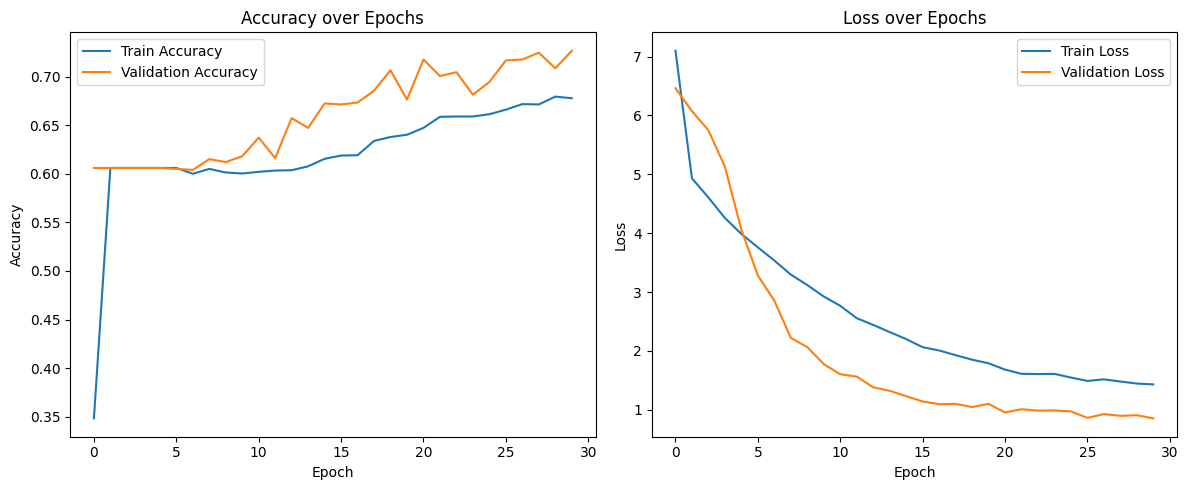

⚠️ Couldn't load existing model: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 995), output.shape=(None, 995)
✅ Final model saved as optimized_lstm_model.keras


In [39]:
model_filename = f"model_{sbert_model_name.replace('-', '_')}.keras"
if os.path.exists(model_filename):
    os.remove(model_filename)
model.save(model_filename)
print(f"💾 Model saved as {model_filename}")

# --- Optional: Plot training history ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Step 12: Save Model as Final ----
final_model_name = "optimized_lstm_model.keras"
if os.path.exists(final_model_name):
    try:
        previous_model = load_model(final_model_name, custom_objects={"AttentionLayer": AttentionLayer})
        _, prev_acc = previous_model.evaluate(X_test, Y_test, verbose=1)
        if test_acc > prev_acc:
            os.replace(model_filename, final_model_name)
            print(f"✅ Final model updated → Accuracy improved from {prev_acc*100:.2f}% → {test_acc*100:.2f}%")
        else:
            print(f"⚠️ Existing model retained → Accuracy {prev_acc*100:.2f}% is better or equal.")
    except Exception as e:
        print(f"⚠️ Couldn't load existing model: {e}")
        os.replace(model_filename, final_model_name)
        print(f"✅ Final model saved as {final_model_name}")
else:
    os.rename(model_filename, final_model_name)
    print(f"✅ Final model saved as {final_model_name}")